In [229]:
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing

from re import sub
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [230]:
df_combined = pd.read_csv('data/combined_preprocessed_comments.csv')

In [231]:
df_combined['comment_no_stopwords'][1]

'protest non voters worst type privileged people. believing allowing worse outcome single issue get worse non vote exact opposite trying help because.'

In [232]:
df_cleaned = df_combined.dropna().drop_duplicates().reset_index(drop=True)

In [233]:
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text 

In [234]:
df_cleaned['comment_no_stopwords_list'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))
df_cleaned['comment_no_stopwords'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))



In [235]:
df_model = df_cleaned.copy()

In [236]:
sent = [row for row in df_model['comment_no_stopwords']]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

INFO - 17:23:07: collecting all words and their counts
INFO - 17:23:07: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:23:08: collected 208185 token types (unigram + bigrams) from a corpus of 257100 words and 13315 sentences
INFO - 17:23:08: merged Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 17:23:08: Phrases lifecycle event {'msg': 'built Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 1.25s', 'datetime': '2024-12-05T17:23:08.882032', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:23:08: exporting phrases from Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 17:23:10: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<10504 phrases, min_count=1, threshold=10.0> from Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=400000

['protest',
 'non_voters',
 'worst',
 'type',
 'privileged',
 'people',
 'believing',
 'allowing',
 'worse',
 'outcome',
 'single_issue',
 'get',
 'worse',
 'non',
 'vote',
 'exact_opposite',
 'trying_help',
 'because']

In [237]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Vocab creation time: {} mins'.format(round((time() - start) / 60, 2)))

INFO - 17:23:10: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-12-05T17:23:10.328737', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:23:10: collecting all words and their counts
INFO - 17:23:10: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


INFO - 17:23:11: collected 30215 word types from a corpus of 223065 raw words and 13315 sentences
INFO - 17:23:11: Creating a fresh vocabulary
INFO - 17:23:11: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 11537 unique words (38.18% of original 30215, drops 18678)', 'datetime': '2024-12-05T17:23:11.293753', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 17:23:11: Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 196229 word corpus (87.97% of original 223065, drops 26836)', 'datetime': '2024-12-05T17:23:11.294892', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 17:23:11: deleting the raw counts dictionary of 30215 items
INFO - 17:23:11: sample=1e-05 downsamples 5676 most-common words
INFO - 17:23:11: Word2Vec lifecycle event {'m

Vocab creation time: 0.02 mins


In [238]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 17:23:11: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 11537 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2024-12-05T17:23:11.759530', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 17:23:12: EPOCH 0 - PROGRESS: at 100.00% examples, 67956 words/s, in_qsize 0, out_qsize 1
INFO - 17:23:12: EPOCH 0: training on 223065 raw words (68197 effective words) took 1.0s, 67888 effective words/s


INFO - 17:23:13: EPOCH 1 - PROGRESS: at 83.90% examples, 60969 words/s, in_qsize 0, out_qsize 0
INFO - 17:23:13: EPOCH 1: training on 223065 raw words (68432 effective words) took 1.2s, 58857 effective words/s
INFO - 17:23:14: EPOCH 2 - PROGRESS: at 83.90% examples, 59723 words/s, in_qsize 0, out_qsize 0
INFO - 17:23:15: EPOCH 2: training on 223065 raw words (68474 effective words) took 1.1s, 61848 effective words/s
INFO - 17:23:16: EPOCH 3 - PROGRESS: at 100.00% examples, 67495 words/s, in_qsize 0, out_qsize 1
INFO - 17:23:16: EPOCH 3: training on 223065 raw words (68020 effective words) took 1.0s, 67403 effective words/s
INFO - 17:23:17: EPOCH 4 - PROGRESS: at 78.72% examples, 57043 words/s, in_qsize 0, out_qsize 0
INFO - 17:23:17: EPOCH 4: training on 223065 raw words (68306 effective words) took 1.1s, 63332 effective words/s
INFO - 17:23:18: EPOCH 5 - PROGRESS: at 57.51% examples, 39836 words/s, in_qsize 0, out_qsize 0
INFO - 17:23:18: EPOCH 5: training on 223065 raw words (68418 e

Time to train the model: 0.56 mins


In [239]:
w2v_model.save("data/word2vec.model")

INFO - 17:23:45: Word2Vec lifecycle event {'fname_or_handle': 'data/word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-12-05T17:23:45.663035', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
INFO - 17:23:45: not storing attribute cum_table
INFO - 17:23:45: saved data/word2vec.model


In [240]:
df_model_export = df_model.copy()
df_model_export['old_comment_no_stopwords'] = df_model_export['comment_no_stopwords']
df_model_export.old_comment_no_stopwords = df_model_export.old_comment_no_stopwords.str.join(' ')
df_model_export['comment_no_stopwords'] = df_model_export['comment_no_stopwords'].apply(lambda x: ' '.join(bigram[x]))

df_model_export.to_csv("data/cleaned_comments_preprocessed.csv", index=False)

In [241]:
word_vectors = Word2Vec.load("data/word2vec.model").wv

INFO - 17:23:49: loading Word2Vec object from data/word2vec.model
INFO - 17:23:49: loading wv recursively from data/word2vec.model.wv.* with mmap=None
INFO - 17:23:49: setting ignored attribute cum_table to None
INFO - 17:23:49: Word2Vec lifecycle event {'fname': 'data/word2vec.model', 'datetime': '2024-12-05T17:23:49.706170', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [242]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [243]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

[('hegemony', 0.9998778700828552),
 ('really_bad', 0.9998763203620911),
 ('symptom', 0.9998756647109985),
 ('releases', 0.9998738765716553),
 ('joe', 0.9998737573623657),
 ('emerged', 0.9998735189437866),
 ('chance', 0.9998730421066284),
 ('anywhere', 0.9998727440834045),
 ('shoot', 0.9998718500137329),
 ('plus', 0.9998712539672852),
 ('around', 0.9998712539672852),
 ('jewish_tradition', 0.9998704195022583),
 ('foreign_military', 0.9998703002929688),
 ('homeless', 0.9998701810836792),
 ('organized_crime', 0.9998698234558105),
 ('perhaps', 0.9998695254325867),
 ('reins', 0.9998692274093628),
 ('argue', 0.9998692274093628),
 ('stock', 0.9998688697814941),
 ('synagogues', 0.9998680353164673),
 ('recognizing', 0.9998680353164673),
 ('years_ago', 0.9998679161071777),
 ('letting', 0.9998676776885986),
 ('gain', 0.9998674392700195),
 ('looks_good', 0.9998673796653748),
 ('65', 0.9998672604560852),
 ('bullets', 0.9998670816421509),
 ('follow_through', 0.9998669624328613),
 ('2021', 0.999866902

In [244]:
positive_cluster_index = 0
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [245]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [246]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [247]:
words[['words', 'sentiment_coeff']].to_csv('data/sentiment_dictionary.csv', index=False)

In [248]:
sentiment_map = pd.read_csv('data/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [255]:
df_weighting

,Unnamed: 0,created_date,subreddit_id,search_query,post_id,comment_id,post_title,comment_original,comment_processed,comment_no_stopwords,upvotes,post_url,comment_url,comment_no_stopwords_list,old_comment_no_stopwords
0,0,2024-10-27 15:32:33,politics,Israel,1gdcy25,lu0s0st,Bernie Sanders to voters skipping presidential...,"News flash, Trump is worse on every single vot...","news flash, trump is worse on every single vot...",news flash trump_worse every_single voting_iss...,8981,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...,"['news', 'flash', 'trump', 'worse', 'every', '...",news flash trump worse every single voting iss...
1,1,2024-10-27 15:08:10,politics,Israel,1gdcy25,lu0nkvc,Bernie Sanders to voters skipping presidential...,Protest non-voters are some of the worst type ...,protest non voters are some of the worst type ...,protest non_voters worst type privileged peopl...,4186,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...,"['protest', 'non', 'voters', 'worst', 'type', ...",protest non voters worst type privileged peopl...
2,2,2024-10-27 15:38:28,politics,Israel,1gdcy25,lu0t4k2,Bernie Sanders to voters skipping presidential...,"Just fucking vote. Local, state and federal. \...","just fucking vote. local, state and federal. t...",fucking vote_local state_federal world mess ye...,3971,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...,"['fucking', 'vote', 'local', 'state', 'federal...",fucking vote local state federal world mess ye...
3,3,2024-10-27 15:18:36,politics,Israel,1gdcy25,lu0pgoz,Bernie Sanders to voters skipping presidential...,Trump wants Israel to annex Palestine.\n\nHarr...,trump wants israel to annex palestine. harris ...,trump wants israel annex palestine harris want...,1394,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...,"['trump', 'wants', 'israel', 'annex', 'palesti...",trump wants israel annex palestine harris want...
4,4,2024-10-27 18:38:06,politics,Israel,1gdcy25,lu1sukf,Bernie Sanders to voters skipping presidential...,This is just objectively true.\n\n&nbsp;\n\nIf...,this is just objectively true. nbsp if you sup...,objectively true nbsp support harris probably ...,887,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...,"['objectively', 'true', 'nbsp', 'support', 'ha...",objectively true nbsp support harris probably ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13310,13313,2023-12-24 02:11:58,baking,cake,18phshr,keouy7k,Cross section of my mums Christmas cake. SHE’S...,Made mine September 10th and have been feeding...,made mine september 10th and have been feeding...,made mine september 10th feeding brandy every_...,62,https://www.reddit.com/r/Baking/comments/18phs...,https://www.reddit.com/r/Baking/comments/18phs...,"['made', 'mine', 'september', '10th', 'feeding...",made mine september 10th feeding brandy every ...
13311,13314,2023-12-24 01:26:12,baking,cake,18phshr,keop0cf,Cross section of my mums Christmas cake. SHE’S...,"I found a fifteen year old fossilised one, wer...","i found a fifteen year old fossilised one, wer...",found fifteen year_old fossilised one going th...,51,https://www.reddit.com/r/Baking/comments/18phs...,https://www.reddit.com/r/Baking/comments/18phs...,"['found', 'fifteen', 'year', 'old', 'fossilise...",found fifteen year old fossilised one going th...
13312,13315,2023-12-24 00:02:00,baking,cake,18phshr,keodw23,Cross section of my mums Christmas cake. SHE’S...,So jealous!! I want to make a chocolate and bo...,so jealous!! i want to make a chocolate and bo...,jealous_! ! want make chocolate bourbon cake n...,51,https://www.reddit.com/r/Baking/comments/18phs...,https://www.reddit.com/r/Baking/comments/18phs...,"['jealous', '!', '!', 'want', 'make', 'chocola...",jealous ! ! want make chocolate bourbon cake n..

In [271]:
final_df = pd.read_csv("data/cleaned_comments_preprocessed.csv")
df_weighting = final_df.copy()
df_weighting = df_weighting[df_weighting['comment_no_stopwords'].str.len()>0]
df_weighting = df_weighting.reset_index(drop=True)

tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df_weighting['comment_no_stopwords'])
features = pd.Series(tfidf.get_feature_names_out())


/Users/kalleleander/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [272]:
missing_words =pd.Series(['every_single'])
features = pd.concat([features, missing_words]).reset_index(drop=True)
transformed = tfidf.transform(df_weighting['comment_no_stopwords'])

In [273]:
df_weighting.shape

(13314, 15)

In [274]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    words = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y: dictionary.get(y, 0), x['comment_no_stopwords'].split()))

In [275]:
%%time
replaced_tfidf_scores = df_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1) # this step takes around 3-4 minutes minutes to calculate

CPU times: user 4.3 s, sys: 128 ms, total: 4.43 s
Wall time: 5.54 s


In [276]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [277]:
replaced_closeness_scores = df_weighting['comment_no_stopwords'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [282]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, df_weighting['comment_no_stopwords']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)

In [283]:
replacement_df['sentiment_score_unsupervised'] = replacement_df['sentiment_coeff'].apply(np.mean)

In [284]:
replacement_df['sentiment_score_unsupervised'] 

0        38.717833
1        52.303687
2        49.477101
3        44.983651
4        48.601446
           ...    
13309    40.783191
13310    33.067769
13311    35.218267
13312    38.985366
13313    41.976558
Name: sentiment_score_unsupervised, Length: 13314, dtype: float64

In [286]:
df_final = pd.read_csv("data/cleaned_comments_preprocessed.csv")
df_final['sentiment_score_unsupervised'] = replacement_df['sentiment_score_unsupervised']

df_final.to_csv('data/cleaned_comments_preprocessed.csv', index=False)

In [ ]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [ ]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('controversial', 0.9999338984489441),
 ('studies', 0.999933660030365),
 ('threatening', 0.9999331831932068),
 ('tonight', 0.999932050704956),
 ('objectively', 0.9999306797981262),
 ('latest', 0.9999306797981262),
 ('trash', 0.9999286532402039),
 ('agenda', 0.9999276995658875),
 ('attended', 0.9999263286590576),
 ('yes.', 0.9999260306358337)]

In [ ]:
# Compute cosine similarity and apply K-Means
cosine_matrix = cosine_similarity(embeddings)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(cosine_matrix)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

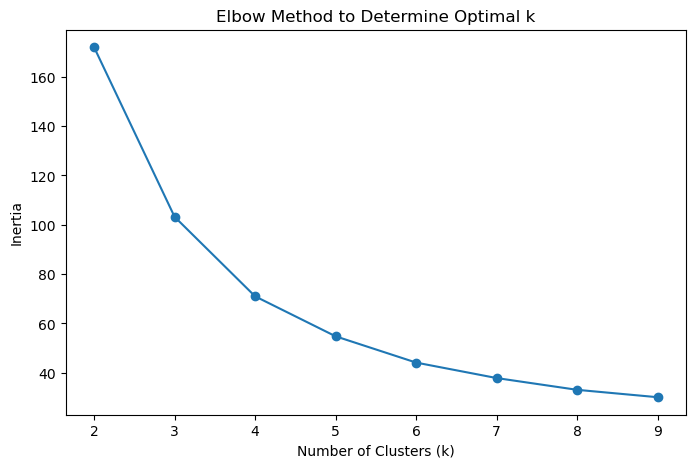

In [ ]:
# Range of k clusters
k_values = range(2, 10)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)  # Use PCA-reduced embeddings for faster computation
    inertia.append(kmeans.inertia_)

# Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()


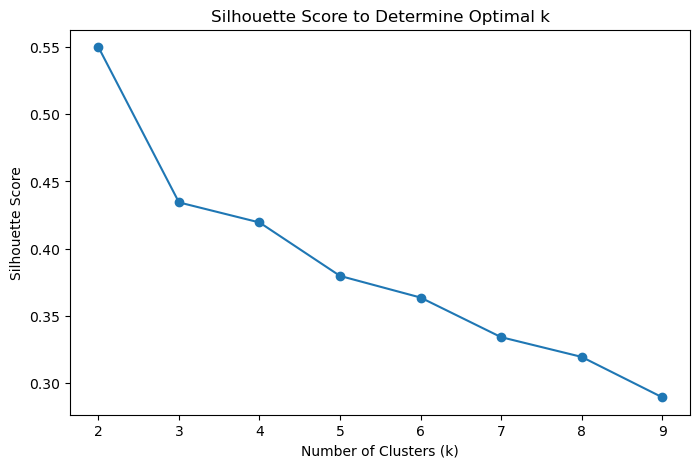

In [ ]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette score vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to Determine Optimal k')
plt.show()


In [ ]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

Cluster 0: ['israel', 'people', 'would', 'like', 'hamas', 'us', 'one', 'even', 'get', 'palestine']


In [ ]:
np.bincount(labels)

array([10998,    44])

In [ ]:
centroids = kmeans.cluster_centers_

# Find most similar words to each centroid
cluster_similar_words = {
    cluster: word_vectors.similar_by_vector(centroid, topn=10, restrict_vocab=None)
    for cluster, centroid in enumerate(centroids)
}

# Analyze the top words in each cluster
for cluster, words in cluster_similar_words.items():
    print(f"Cluster {cluster}: {[word[0] for word in words]}")

Cluster 0: ['local,', 'approve', 'policies,', 'sought', 'trouble.', 'extends', 'senses', '66', 'object', 'regardless.']
Cluster 1: ['local,', 'approve', 'policies,', 'sought', 'trouble.', 'extends', 'senses', '66', 'regardless.', 'object']
